In [1]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import cv2 
import os
import sys
import torchvision.models as models
from tqdm import tqdm

#to import modules from py scripts
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from dataloader import NYUDatasetRGBD
from bts import BTS


In [2]:
#TEST_DIR = '/scratch365/palarcon/Scene-Reconstruction/BTS/dataset/test_paths.txt'
#MODEL_DIR = '/scratch365/palarcon/Scene-Reconstruction/BTS/logs/checkpoints/model-49'
#TRAIN_DIR = '/scratch365/palarcon/Scene-Reconstruction/BTS/dataset/train_paths.txt'

TEST_DIR = 'dataset/test_paths.txt'
MODEL_DIR = 'logs/checkpoints/model-49'
#TRAIN_DIR = '/scratch365/palarcon/Scene-Reconstruction/BTS/dataset/train_paths.txt'

In [3]:
def unnormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor
  

def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    d1 = (thresh < 1.25).mean()
    d2 = (thresh < 1.25 ** 2).mean()
    d3 = (thresh < 1.25 ** 3).mean()

    rms = (gt - pred) ** 2
    rms = np.sqrt(rms.mean())

    log_rms = (np.log(gt) - np.log(pred)) ** 2
    log_rms = np.sqrt(log_rms.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)
    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    err = np.log(pred) - np.log(gt)
    silog = np.sqrt(np.mean(err ** 2) - np.mean(err) ** 2) * 100

    err = np.abs(np.log10(pred) - np.log10(gt))
    log10 = np.mean(err)

    return [silog, abs_rel, log10, rms, sq_rel, log_rms, d1, d2, d3]

def eval(gt_depth, est_depth):

    est_depth[ est_depth < 1e-3] = 1e-3
    est_depth[ est_depth > 10] = 10
    est_depth[np.isinf( est_depth )] = 10
    est_depth[np.isnan( est_depth )] = 1e-3

    valid_mask = np.logical_and(gt_depth > 1e-3, gt_depth  < 10)
    eval_mask = np.zeros(valid_mask.shape)
    eval_mask[45:471, 41:601] = 1
    valid_mask = np.logical_and(valid_mask, eval_mask)
    measures = compute_errors(est_depth[valid_mask], gt_depth [valid_mask])

    return measures

In [4]:
print("Pytorch Version: ", torch.__version__)
print(f"CUDA Version: {torch.version.cuda}")
print("Number of GPUS ", torch.cuda.device_count())
#print("Properties of first CUDA:\n",torch.cuda.get_device_properties("cuda:0"))
#print("Properties of second CUDA:\n",torch.cuda.get_device_properties("cuda:1"))

Pytorch Version:  1.12.0
CUDA Version: None
Number of GPUS  0


In [5]:
to_device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = BTS(max_depth=10, bts_size=512)
checkpoint = torch.load(MODEL_DIR, map_location=to_device)
model.load_state_dict(checkpoint['model'] )
#model.eval()
model.to(to_device)
dataset_test = NYUDatasetRGBD(TEST_DIR, mode='test', isCAML=False)

/home/tony/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/tony/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/tmp/ipykernel_3042799/3413149912.py:46: RuntimeWarning: divide by zero encountered in true_divide
  plt.imshow(1/depth_gt, cmap='gray')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


silog: 6.681245269053088
abs_rel: 0.056681133806705475
log10: 0.02610906958580017
rms: 0.13846635818481445
sq_rel: 0.009953342378139496
log_rms: 0.0866507738828659
d1: 0.9930933325738373
d2: 0.9982768932813079
d3: 0.9995799037338726

Finished Inferance in 1.1893644332885742 seconds
3.9203653
3.944


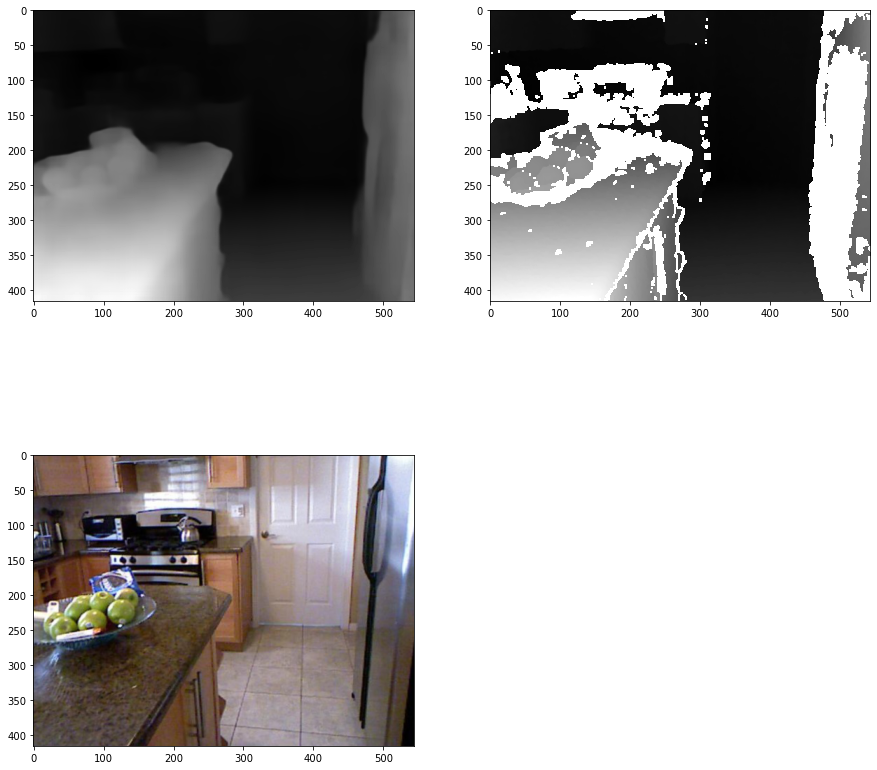

In [10]:
index = 326 #DO NOT EXCEED INDEX 653
sample = dataset_test.__getitem__(index)
image = torch.unsqueeze(sample['image'],0).to(to_device)
depth_gt = torch.unsqueeze(sample['depth'],0).to(to_device)
focal = torch.unsqueeze(sample['focal'], 0).to(to_device)


metric_measures = [0,0,0,0,0,0,0,0,0] #[silog, abs_rel, log10, rms, sq_rel, log_rms, d1, d2, d3]
inference_time = 0
with torch.no_grad():
   
    start = time.time()
    lpg8x8, lpg4x4, lpg2x2, reduc1x1, depth_est = model(image, focal)
    end = time.time()
    inference_time += (end-start)
    
    depth_gt = depth_gt.cpu().numpy().squeeze()
    depth_est = depth_est.cpu().numpy().squeeze()
    measures = eval(depth_gt,depth_est)
    
    

#printing results
metric_name = ['silog', 'abs_rel', 'log10', 'rms', 'sq_rel', 'log_rms', 'd1', 'd2', 'd3']
for i in range(len(metric_name)):
    print(f'{metric_name[i]}: {measures[i]}')
print(f'\nFinished Inferance in {inference_time} seconds')

#displaying image
depth_gt = np.expand_dims(depth_gt, 0)
depth_gt = np.transpose(depth_gt, (1, 2, 0))
depth_est = np.expand_dims(depth_est, 0)
depth_est = np.transpose(depth_est, (1, 2, 0))
original_image = unnormalize(image[0,:,:,:]).cpu() *255
original_image = np.transpose(np.array(original_image), (1, 2, 0))

print(np.max(depth_est))
print(np.max(depth_gt))

rows= 2
columns = 2
fig = plt.figure(figsize=(15, 15))
fig.add_subplot(rows, columns, 1)
plt.imshow(1/depth_est, cmap='gray')
fig.add_subplot(rows, columns, 2)
plt.imshow(1/depth_gt, cmap='gray')
fig.add_subplot(rows, columns, 3)
plt.imshow(original_image)